In [34]:
import firebase_admin
import pandas as pd
import numpy as np
from firebase_admin import credentials, firestore
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from scipy.stats import skew, kurtosis

# Firebase Initialization
cred = credentials.Certificate("adminkey.json")
#firebase_admin.initialize_app(cred)
db = firestore.client()

# Constants
INCLUDE_ONLY = ['Stephen', 'Lillian', 'Ren', 'Yuanheng', 'Ethan Shao','z']
ACTIVITIES = ['sit', 'walk', 'upstair']
LABEL_MAP = {activity: i for i, activity in enumerate(ACTIVITIES)}
TIME_START, TIME_END = 500, 6000  
CHUNK_SIZE = 1  # in seconds
SAMPLING_RATE = 100  # Hz
OVERLAP = 0.5  # 50% overlap

In [35]:
def extract_features(chunk):
    """Extract features from a chunked acceleration segment with selected statistics."""
    feature_vector = []
    
    for axis in ['x', 'y', 'z']:
        data_series = pd.Series(chunk[axis])
        # Apply smoothing
        smoothed_data = data_series.rolling(window=5, min_periods=1).mean()
        feature_vector.extend([
            smoothed_data.mean(),                  # Mean
            smoothed_data.median(),                # Median
            smoothed_data.std(),                   # Standard Deviation
            smoothed_data.var(),                   # Variance
            smoothed_data.min(),                   # Minimum
            smoothed_data.max(),                   # Maximum
        ])
    return feature_vector

In [36]:
def fetch_data(collection_name, activities, include_only):
    """Fetch raw data from Firestore."""
    data_raw, docs = [], []
    
    for person in db.collection(collection_name).stream():
        person_name = str(person.to_dict().get('name', ''))
        if person_name not in include_only:
            continue

        for activity in activities:
            for recording in db.collection(collection_name).document(person_name).collection(activity).stream():
                record = recording.to_dict()
                if 'acceleration' not in record:
                    continue

                df = pd.DataFrame(record['acceleration'])
                if 'time' in df.columns:
                    df = df[(df['time'] >= TIME_START) & (df['time'] <= TIME_END)].drop(columns=['time'])
                    data_raw.append(df)
                    docs.append({'activity': activity})

    return data_raw, docs
training_data_raw, training_docs = fetch_data("training", ACTIVITIES, INCLUDE_ONLY)
testing_data_raw, testing_docs = fetch_data("testing", ACTIVITIES, INCLUDE_ONLY)

In [37]:
def chunk_data_with_overlap(data_raw, docs, chunk_size, activities, sampling_rate, overlap=0.5):
    """Chunk raw acceleration data into smaller labeled segments using overlapping windows."""
    data, labels = [], []
    chunk_samples = int(chunk_size * sampling_rate)
    step = int(chunk_samples * (1 - overlap))  # compute step size based on overlap

    for i, df in enumerate(data_raw):
        # Slide over the data with the defined step
        for start in range(0, len(df) - chunk_samples + 1, step):
            end = start + chunk_samples
            chunk = df.iloc[start:end]
            activity = docs[i]['activity']
            label = activities.index(activity)
            data.append(extract_features(chunk))
            labels.append(label)
    return np.array(data), np.array(labels)

# Use overlapping window chunking
X_train, y_train = chunk_data_with_overlap(training_data_raw, training_docs, CHUNK_SIZE, ACTIVITIES, SAMPLING_RATE, OVERLAP)
X_test, y_test = chunk_data_with_overlap(testing_data_raw, testing_docs, CHUNK_SIZE, ACTIVITIES, SAMPLING_RATE, OVERLAP)

In [45]:
import matplotlib.pyplot as plt

# List of chunk sizes to experiment with (in seconds)
chunk_sizes = [0.25,0.5,1,1.375,2.75,5.5]

accuracies = []
best_chunk_size = None

# Loop through the chunk sizes to find the best one
for chunk_size in chunk_sizes:
    # Use overlapping window chunking
    X_train, y_train = chunk_data_with_overlap(training_data_raw, training_docs, chunk_size, ACTIVITIES, SAMPLING_RATE, OVERLAP)
    X_test, y_test = chunk_data_with_overlap(testing_data_raw, testing_docs, chunk_size, ACTIVITIES, SAMPLING_RATE, OVERLAP)

    # Build a pipeline to scale data and train KNN
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ])

    # Define hyperparameter grid for GridSearchCV
    param_grid = {
        'knn__n_neighbors': list(range(1, 16)),
        'knn__metric': ['manhattan', 'euclidean'],
        'knn__weights': ['uniform', 'distance']
    }

    # Use GridSearchCV for parameter tuning with cross-validation on training data
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    print(f"Best Parameters for chunk size {chunk_size}:", grid_search.best_params_)

    # Evaluate the best model on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    print(f"KNN Test Accuracy for chunk size {chunk_size}: {accuracy:.2f}")
# Identify the best chunk size based on accuracy
best_chunk_size = chunk_sizes[np.argmax(accuracies)]
print(f"Best Chunk Size: {best_chunk_size} seconds")

Best Parameters for chunk size 0.25: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}
KNN Test Accuracy for chunk size 0.25: 0.80
Best Parameters for chunk size 0.5: {'knn__metric': 'manhattan', 'knn__n_neighbors': 6, 'knn__weights': 'uniform'}
KNN Test Accuracy for chunk size 0.5: 0.82
Best Parameters for chunk size 1: {'knn__metric': 'manhattan', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}
KNN Test Accuracy for chunk size 1: 0.84
Best Parameters for chunk size 1.375: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}
KNN Test Accuracy for chunk size 1.375: 0.85
Best Parameters for chunk size 2.75: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}
KNN Test Accuracy for chunk size 2.75: 0.86
Best Parameters for chunk size 5.5: {'knn__metric': 'manhattan', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
KNN Test Accuracy for chunk size 5.5: 0.84
Best Chunk Size: 2.75 seconds


KNN Test Accuracy with Best Chunk Size (2.75 sec): 0.86
              precision    recall  f1-score   support

         sit       1.00      1.00      1.00        36
        walk       0.83      0.69      0.76        36
     upstair       0.76      0.87      0.81        39

    accuracy                           0.86       111
   macro avg       0.86      0.86      0.86       111
weighted avg       0.86      0.86      0.85       111



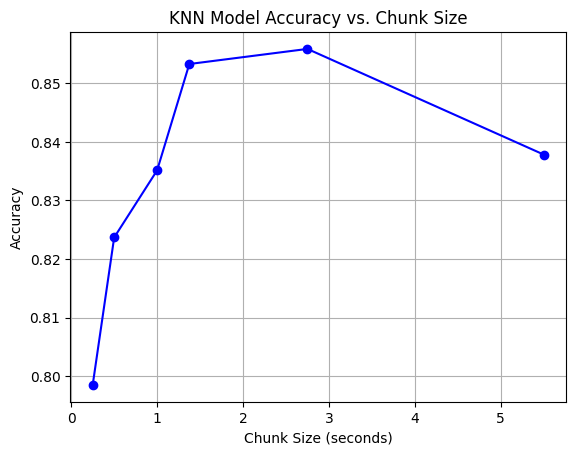

In [47]:
X_train, y_train = chunk_data_with_overlap(training_data_raw, training_docs, best_chunk_size, ACTIVITIES, SAMPLING_RATE, OVERLAP)
X_test, y_test = chunk_data_with_overlap(testing_data_raw, testing_docs, best_chunk_size, ACTIVITIES, SAMPLING_RATE, OVERLAP)

# Build and train the final model with the best chunk size
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Hyperparameters for GridSearchCV
param_grid = {
    'knn__n_neighbors': list(range(1, 16)),
    'knn__metric': ['manhattan', 'euclidean'],
    'knn__weights': ['uniform', 'distance']
}

# Perform GridSearchCV on the full training data with the best chunk size
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Print the final evaluation results
print(f"KNN Test Accuracy with Best Chunk Size ({best_chunk_size} sec): {accuracy:.2f}")
print(classification_report(y_test, y_pred, target_names=ACTIVITIES))

# Plot the accuracy for each chunk size
plt.plot(chunk_sizes, accuracies, marker='o', linestyle='-', color='b')
plt.title('KNN Model Accuracy vs. Chunk Size')
plt.xlabel('Chunk Size (seconds)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

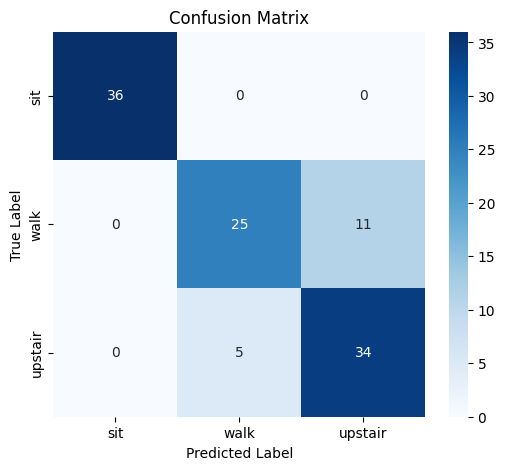

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get actual labels present in y_test
unique_labels = np.unique(y_test)
filtered_activities = [ACTIVITIES[i] for i in unique_labels]

# Create confusion matrix with filtered labels
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=filtered_activities, yticklabels=filtered_activities)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()